<a href="https://colab.research.google.com/github/saffarizadeh/INSY4054/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://saffarizadeh.com/Logo.png" width="300px"/>

# *INSY 4054: Emerging Technologies*

# **Trained Models and Transfer Learning**

Instructor: Dr. Kambiz Saffarizadeh

---

Source: https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1

Read the complete tutorial: https://www.tensorflow.org/hub/tutorials/tf2_object_detection

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
from PIL import Image
from PIL import ImageColor
from PIL import ImageFont
from PIL import ImageDraw

In [ ]:
detector = hub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1").signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg

--2021-02-22 16:49:10--  https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 779201 (761K) [image/jpeg]
Saving to: ‘Naxos_Taverna.jpg’

Naxos_Taverna.jpg   100%[===================>] 760.94K  --.-KB/s    in 0.07s   

2021-02-22 16:49:10 (10.6 MB/s) - ‘Naxos_Taverna.jpg’ saved [779201/779201]



In [ ]:
image_d = tf.keras.preprocessing.image.load_img('Naxos_Taverna.jpg', target_size=(856, 1280))

In [ ]:
image_array = tf.keras.preprocessing.image.img_to_array(image_d, dtype='uint8')

In [ ]:
image_array_float = image_array[tf.newaxis, ...] / 255.0

In [ ]:
image_array_float = image_array_float.astype('float32') # I seprated these steps to make sure you can follow what we are doing here

In [ ]:
image_tensor = tf.convert_to_tensor(image_array_float)

In [ ]:
detector_output = detector(image_tensor)

In [ ]:
result = {key:value.numpy() for key,value in detector_output.items()}

In [ ]:
#@title Functions to draw the boxes on the image (Click play to run the code; double-click to see the code)
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

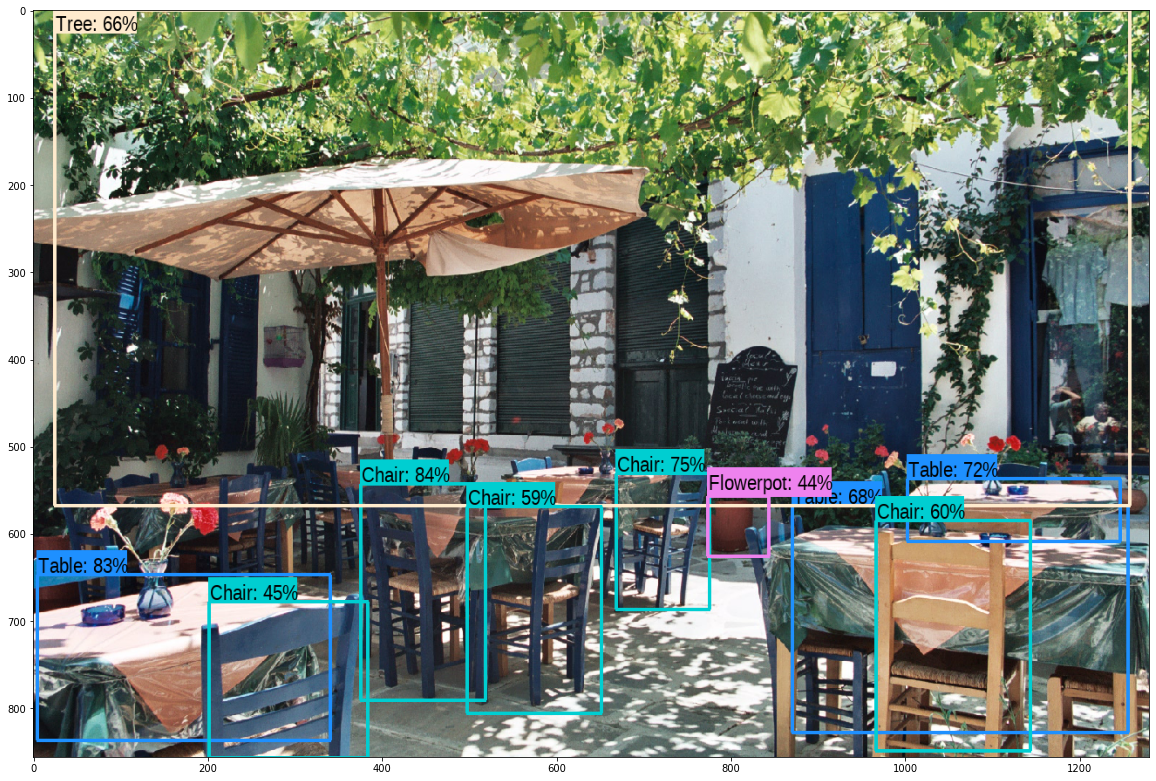

In [ ]:
image_with_boxes = draw_boxes(
      image_array.copy(),
      result["detection_boxes"],
      result["detection_class_entities"],
      result["detection_scores"])

fig = plt.figure(figsize=(20, 15))
plt.grid(False)
plt.imshow(image_with_boxes)